# Alegeri prezidentiale Romania 2025
Scopul lucrarii este sa extrag mai multe informatii de pe site-uri si aplicatii folosite de popurul roman pentru a se informa despre candidatii ale alegerilor prezidentiale din turul 2 (2025)
Urmaresc:
*   sentimentele oameniilor asupra alegeriilor prezidentiale

*   posibilitatea de a vedea daca o persoana a votat cu unul din candidati utilizand un model de ai pe baza de sentimente


# Project Settings
This section is reserved for the settings of the project the settings are the following variables, each variable has it's explanation around it

In [ ]:
# The following variables are the settings for the project i will explain each one:


# project root is given here we will have all the files that you need to have to run the project
project_root = '/content/drive/MyDrive/Colab Notebooks/AVD_labs/Proiect Examen AVD/'

# The files that you will need are the .env and requirements.txt
# both files will be given with the project but .env should be populated with the necessary keys

# True for fetching - False for getting the data from previous fetch (csv)
fetch = False
# True for cleaning - False for getting the data from previous clean (csv)
clean = False
# True for sentiments - False for getting the data from previous setiments analysis (csv)
sentiments = False

# for reddit it takes all the comments from {request_limit} posts for every subreddit
reddit_limit = 10 # posts (all the comments from the post)

# for twitter it takes {request_limit} comments for every thread
twitter_limit = 10 # tweets

# for youtube it takes {request_limit} comments for every video
youtube_limit = 100 # comments

# list of the name of subbreddits that we fetch from
subreddits_list = [
    'Romania',
    'WomenRO',
    'politica',
    # 'europe', # trebuie sa vad in functie de ce fac search ul la asta si ar trebuii si un feature de language
    ]


# list of the name of twitter threads that we fetch from
twitter_threads_list = [
    'alegeri Romania',
    # '(alegeri OR alegeri2025 OR "alegeri prezidentiale" OR "președintele României" OR "Romania elections") '
    # 'lang:ro has:links -is:retweet' # optiune mai buna i guess

    #     conversation_id = tweet.conversation_id
    # query = f'conversation_id:{conversation_id}' # alta optiune i guess

    # query += " min_faves:10 min_retweets:5" # destul de relevanta pentru exposure

    ]


# list of the ids of the videos that we fetch from
youtube_video_ids_list = [
    '1N76UD-o95I', # Dezbatere prezidențială George Simion - Nicușor Dan la Euronews România (https://www.youtube.com/watch?v=1N76UD-o95I)
    'XKsToC5ELoc', # Who is Nicușor Dan? (https://www.youtube.com/watch?v=XKsToC5ELoc)
    'i3kfDCPNonM', # Who is George Simion? (https://www.youtube.com/watch?v=i3kfDCPNonM)
    'nAZA9oGEoHw', # ⭕️ LIVE ANTENA 3 CNN: EXIT POLL- Alegeri prezidenţiale 2025 cu Mihai Gâdea (https://www.youtube.com/watch?v=nAZA9oGEoHw)
    'd9U66yU8dYE', # 🔴LIVE | M.C.N. Podcast cu Candidații la Prezidențiale: Nicușor Dan și George Simion (https://www.youtube.com/watch?v=d9U66yU8dYE)
    'L7EymYXIVCo', # Nicușor Dan și George Simion, față în față. Ce spun candidații despre devalorizarea leului (https://www.youtube.com/watch?v=L7EymYXIVCo)
    ]


# Dependencies Installation
In this section we are mounting google drive for keeping the data that we are extracting and the consistency of the project between sessions, we are installing the requirements from requirements.txt and importing all the necessary libraries for running the project

In [ ]:
from google.colab import drive
import torch

drive.mount('/content/drive')

# use GPU else use CPU
device = 0 if torch.cuda.is_available() else -1

requirements_file_path = project_root + 'requirements.txt'

%pip -q install -r "{requirements_file_path}"
!python -m spacy download ro_core_news_sm

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 91.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('ro_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import os
from dotenv import load_dotenv
import time
from datetime import datetime

import asyncio
import swifter

import asyncpraw
import tweepy
from googleapiclient.discovery import build

import re
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import spacy
import emoji
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import (
  RandomForestRegressor,
  RandomForestClassifier
)
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    mean_absolute_percentage_error,
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    ConfusionMatrixDisplay,
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score
)
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from itertools import tee, islice, zip_longest
from transformers import pipeline
from datasets import Dataset
from huggingface_hub import login
from scipy.sparse import issparse
from collections import defaultdict, Counter


# APIs Setup
This section is reserved for praw, tweepy and youtube api setups
In here we are retrieving the env vars (api keys, bearer tokens) saving them in variables and we are creating the 3 clients

In [ ]:
# Reading secretes from secrets_file_path
env_file_path = project_root + '.env'
load_dotenv(env_file_path)

# Hugging Face
hugging_face_token = os.getenv('HUGGING_FACE_TOKEN', '')

# Reddit
reddit_client_id = os.getenv('REDDIT_CLIENT_ID', '')
reddit_client_secret = os.getenv('REDDIT_CLIENT_SECRET', '')
reddit_user_agent = os.getenv('REDDIT_USER_AGENT', '')

# Twitter
twitter_bearer_token = os.getenv('TWITTER_BEARER_TOKEN', '')

# YouTube
youtube_api_key = os.getenv('YOUTUBE_API_KEY', '')

In [ ]:
# Hugging Face
login(token=hugging_face_token)

# Praw setup
reddit = asyncpraw.Reddit(client_id=reddit_client_id,
                          client_secret=reddit_client_secret,
                          user_agent=reddit_user_agent)

# Tweepy setup
twitter = tweepy.Client(bearer_token=twitter_bearer_token)


# Youtube build setup
youtube = build('youtube', 'v3', developerKey=youtube_api_key)

# Data Collection
In this section we are fetching the data from the platforms and the chosen subject verify settings section for number of posts/comments that we want to extract and for the subreddits, threads and videos we want to extract them from

### Useful functions

In [ ]:
def save_to_csv(data, root_path="/", file_path="data.csv"):
    if isinstance(data, str):
      df = pd.DataFrame(data)
    if isinstance(data, pd.DataFrame):
      df = data
    full_path = root_path + file_path
    df.to_csv(full_path, index=False, encoding='utf-8-sig')
    return df, full_path

def read_from_csv(root_path="/", file_path="data.csv"):
    full_path = root_path + file_path
    return pd.read_csv(full_path) if os.path.exists(full_path) else pd.DataFrame()

### Fetching functions

In [ ]:
# reddit

async def fetch_reddit_data(subreddits_list, limit=10):
    reddit_data = []
    for subreddit_name in subreddits_list:
      try:
          subreddit = await reddit.subreddit(subreddit_name)
          async for post in subreddit.search('alegeri 2025', limit=limit):
              await post.load()
              post_title = post.title
              await post.comments.replace_more(limit=0)
              for comment in post.comments.list():
                  reddit_data.append({
                      'Platform': 'Reddit',
                      'Source Title': post_title,
                      'Author': comment.author.name if comment.author else '[deleted]',
                      'Content': comment.body,
                      'Likes': comment.score,
                      'Replies': None,
                      'Created At': datetime.fromtimestamp(comment.created_utc),
                      'Extra Info': {
                          'post_id': post.id,
                          'comment_id': comment.id,
                          'subreddit': subreddit_name,
                          'url': f"https://reddit.com{comment.permalink}"
                      }
                  })
      except Exception as e:
          print(f"Failed to fetch subreddit {subreddit_name}: {e}")
    return reddit_data


In [ ]:
# twitter(x)

def fetch_twitter_data(twitter_threads_list, limit=10):
  twitter_data = []
  delay_between_requests=900 # 15 min
  for i in range(limit):
    try:
      tweets = twitter.search_recent_tweets(
          query=twitter_threads_list[0],
          max_results=limit,
          tweet_fields=["created_at", "public_metrics", "author_id"]
      )

      for t in tweets.data:
            twitter_data.append({
                'Platform': 'Twitter',
                'Source Title': t.text[:100],
                'Author': t.author_id,
                'Content': t.text,
                'Likes': t.public_metrics['like_count'],
                'Replies': t.public_metrics['reply_count'],
                'Created At': t.created_at,
                'Extra Info': {
                    'tweet_id': t.id,
                    'retweets': t.public_metrics['retweet_count'],
                    'quotes': t.public_metrics['quote_count']
                }
            })

      time.sleep(delay_between_requests)

    except Exception as e:
        print(f"Error: {e}")
    return twitter_data


In [ ]:
# youtube

def fetch_youtube_data(youtube_video_ids_list, limit=10):
  youtube_data = []
  for youtube_video_id in youtube_video_ids_list:
    try:
        request = youtube.commentThreads().list(
            part='snippet',
            videoId=youtube_video_id,
            maxResults=limit,
            textFormat='plainText'
        )
        response = request.execute()

        for item in response['items']:
            top_comment = item['snippet']['topLevelComment']['snippet']
            author = top_comment.get('authorDisplayName')
            text = top_comment.get('textDisplay')
            likes = top_comment.get('likeCount')
            reply_count = item['snippet'].get('totalReplyCount', 0)
            comment_id = item['snippet']['topLevelComment']['id']

            replies = []
            if reply_count > 0:
                reply_response = youtube.comments().list(
                    part='snippet',
                    parentId=comment_id,
                    maxResults=limit
                ).execute()

                for reply_item in reply_response['items']:
                    reply = reply_item['snippet']
                    replies.append(f"{reply['authorDisplayName']}: {reply['textDisplay']}")

            youtube_data.append({
                  'Platform': 'YouTube',
                  'Source Title': f"Top comment ID: {comment_id}",
                  'Author': author,
                  'Content': text,
                  'Likes': likes,
                  'Replies': replies,
                  'Created At': top_comment.get('publishedAt'),
                  'Extra Info': {
                      'video_id': youtube_video_ids_list[0],
                      'reply_count': reply_count
                  }
              })
    except Exception as e:
        print(f"Failed to fetch youtube video with id: {youtube_video_id}: {e}")

  return youtube_data



### Creating the DataFrames

In [ ]:
# combine dataframes

reddit_df = pd.DataFrame()
twitter_df = pd.DataFrame()
youtube_df = pd.DataFrame()

if fetch:
  reddit_data = await fetch_reddit_data(subreddits_list, reddit_limit)
  reddit_df, reddit_csv_path = save_to_csv(reddit_data, project_root, 'reddit_data.csv')
  print(reddit_csv_path)

  twitter_data = fetch_twitter_data(twitter_threads_list, twitter_limit)
  twitter_df, twitter_csv_path = save_to_csv(twitter_data, project_root, 'twitter_data.csv')
  print(twitter_csv_path)

  youtube_data = fetch_youtube_data(youtube_video_ids_list, youtube_limit)
  youtube_df, youtube_csv_path = save_to_csv(youtube_data, project_root, 'youtube_data.csv')
  print(youtube_csv_path)

  compound_data = pd.concat([reddit_df, twitter_df, youtube_df], ignore_index=True)
  compound_df, compound_csv_path = save_to_csv(compound_data, project_root, 'compound_data.csv')
  print(compound_csv_path)
else:
  reddit_df = read_from_csv(project_root, 'reddit_data.csv')
  twitter_df = read_from_csv(project_root, 'twitter_data.csv')
  youtube_df = read_from_csv(project_root, 'youtube_data.csv')




# Data Cleaning (Adding useful features)
In this section we are manipulating the content feature so that we can make more useful features like words, bigrams, trigrams, td-idf

### Setup before cleaning

In [ ]:
nlp = spacy.load("ro_core_news_sm")
link_pattern = re.compile(r'https?://\S+|www\.\S+|pic\.twitter\.com/\S+|t\.co/\S+')
emoji_pattern = re.compile(r'^[\W_]+$')
media_pattern = re.compile(r'\[?(photo|image|video|gif|media)\]?$', re.IGNORECASE)
stretched_letter_pattern = re.compile(r'(\w)\1{2,}')

### Cleaning functions

In [ ]:
def ngrams(tokens, n):
    return ["_".join(gram) for gram in zip(*(islice(seq, i, None) for i, seq in enumerate(tee(tokens, n))))]

In [ ]:
def is_emoji(s):
    return s in emoji.EMOJI_DATA

In [ ]:
def is_meaningful(text):
    if not isinstance(text, str):
        return False

    text = text.strip()
    if not text or text == "[deleted]" or text == "[removed]":
        return False

    if link_pattern.fullmatch(text):
        return False
    if emoji_pattern.fullmatch(text):
        return False
    if media_pattern.fullmatch(text):
        return False

    if len(text.split()) <= 3 and stretched_letter_pattern.search(text.lower()):
        return False

    doc = nlp(text)

    if all(
        token.is_stop or token.is_punct or token.pos_ in {"INTJ", "SPACE"}
        for token in doc
    ):
        return False

    return True

In [ ]:
def is_meaningful_token(token):
  return (
      not token.is_stop and not token.is_punct
      and not token.is_space and not token.like_url
      and token.lemma_.lower() not in {"photo", "image", "video", "gif", "media"}
      and not is_emoji(token.text)
  )

In [ ]:
def stringify_ngram_list(ngram_list):
    return ['_'.join(ng) if isinstance(ng, (list, tuple)) else str(ng) for ng in ngram_list]


### Cleaning pipeline

In [ ]:

def clean_dataframe(df):
    df = df[df['Content'].apply(is_meaningful)].copy()
    df.reset_index(drop=True, inplace=True)

    df = df[df['Author'] != "AutoModerator"].copy()
    df.reset_index(drop=True, inplace=True)

    cleaned_texts = []
    tokens_list = []
    bigrams_list = []
    trigrams_list = []

    for doc in nlp.pipe(df['Content'].astype(str), batch_size=50):
        tokens = [token.lemma_.lower() for token in doc if is_meaningful_token(token)]
        cleaned = " ".join(tokens)
        bigrams = list(ngrams(tokens, 2))
        trigrams = list(ngrams(tokens, 3))

        cleaned_texts.append(cleaned)
        tokens_list.append(tokens)
        bigrams_list.append(bigrams)
        trigrams_list.append(trigrams)

    df['Cleaned Content'] = cleaned_texts
    df['Tokens'] = tokens_list
    df['Bigrams'] = bigrams_list
    df['Trigrams'] = trigrams_list

    tfidf = TfidfVectorizer()
    tfidf_matrix = tfidf.fit_transform(df['Cleaned Content'])
    tfidf_dense = tfidf_matrix.toarray()
    feature_names = tfidf.get_feature_names_out()

    top_terms = [feature_names[vec.argmax()] if vec.sum() > 0 else "" for vec in tfidf_dense]
    df['Top TFIDF Term'] = top_terms

    bigram_strs = [' '.join(stringify_ngram_list(bigrams)) for bigrams in df['Bigrams']]
    bigram_vectorizer = TfidfVectorizer(token_pattern=r'[^ ]+')
    bigram_matrix = bigram_vectorizer.fit_transform(bigram_strs)
    bigram_features = bigram_vectorizer.get_feature_names_out()

    trigram_strs = [' '.join(stringify_ngram_list(trigrams)) for trigrams in df['Trigrams']]
    trigram_vectorizer = TfidfVectorizer(token_pattern=r'[^ ]+')
    trigram_matrix = trigram_vectorizer.fit_transform(trigram_strs)
    trigram_features = trigram_vectorizer.get_feature_names_out()

    df['Top TFIDF Bigram'] = [
        bigram_features[row.argmax()] if row.sum() > 0 else ""
        for row in bigram_matrix.toarray()
    ]

    df['Top TFIDF Trigram'] = [
        trigram_features[row.argmax()] if row.sum() > 0 else ""
        for row in trigram_matrix.toarray()
    ]

    return df


In [ ]:
if clean:
  compound_data = read_from_csv(project_root, 'compound_data.csv')
  cleaned_compound_data = clean_dataframe(compound_data)
  cleaned_compound_data , cleaned_compound_csv_path = save_to_csv(cleaned_compound_data, project_root, 'cleaned_compound_data.csv')
  print(cleaned_compound_csv_path)
else:
  cleaned_compound_data = read_from_csv(project_root, 'cleaned_compound_data.csv')

/content/drive/MyDrive/Colab Notebooks/AVD_labs/Proiect Examen AVD/cleaned_compound_data.csv


# Data Analysis (text, sentiment)
In this section we are analysing td-idf, bigrams, trigrams and we are making a feature for sentiment score related to the content feature

In [ ]:
star_map = {
    "1 star": "very negative",
    "2 stars": "negative",
    "3 stars": "neutral",
    "4 stars": "positive",
    "5 stars": "very positive"
}

sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model="nlptown/bert-base-multilingual-uncased-sentiment",
    tokenizer="nlptown/bert-base-multilingual-uncased-sentiment",
    device=device,
    truncation=True,
    max_length=512
)

emotion_pipeline = pipeline(
    "text-classification",
    model="cardiffnlp/twitter-roberta-large-emotion-latest",
    tokenizer="cardiffnlp/twitter-roberta-large-emotion-latest",
    device=device,
    truncation=True,
    max_length=512,
    top_k=1
)


def sentiment_analysis(df):
    dataset = Dataset.from_pandas(df[['Cleaned Content']])

    def analyze(batch):
        texts = [t for t in batch['Cleaned Content'] if isinstance(t, str) and t.strip() != ""]

        if not texts:
            batch['Sentiment'] = []
            batch['Sentiment Score'] = []
            batch['Emotion'] = []
            batch['Emotion Score'] = []
            return batch

        sentiment_results = sentiment_pipeline(texts)
        emotion_results = emotion_pipeline(texts)

        sentiments, sentiment_scores = [], []
        emotions, emotion_scores = [], []

        idx = 0
        for text in batch['Cleaned Content']:
            if isinstance(text, str) and text.strip() != "":
                sentiment = sentiment_results[idx]
                label = sentiment['label'].strip().lower()
                sentiments.append(star_map.get(label, 'unknown'))
                sentiment_scores.append(sentiment['score'])

                emotion = emotion_results[idx][0]
                emotions.append(emotion['label'])
                emotion_scores.append(emotion['score'])

                idx += 1
            else:
                sentiments.append("unknown")
                sentiment_scores.append(0.0)
                emotions.append("unknown")
                emotion_scores.append(0.0)

        batch['Sentiment'] = sentiments
        batch['Sentiment Score'] = sentiment_scores
        batch['Emotion'] = emotions
        batch['Emotion Score'] = emotion_scores
        return batch

    dataset = dataset.map(analyze, batched=True, batch_size=16 if device != -1 else 8)

    result_df = pd.DataFrame(dataset)

    df['Sentiment'] = result_df['Sentiment']
    df['Sentiment Score'] = result_df['Sentiment Score']
    df['Emotion'] = result_df['Emotion']
    df['Emotion Score'] = result_df['Emotion Score']

    return df

Device set to use cuda:0
Device set to use cuda:0


In [ ]:
if sentiments:
  complete_compound_data = sentiment_analysis(cleaned_compound_data) # < 3 min (GPU) < 2 h (CPU)
  complete_compound_data, complete_compound_csv_path = save_to_csv(complete_compound_data, project_root, 'complete_compound_data.csv')
  print(complete_compound_csv_path)
else:
  complete_compound_data = read_from_csv(project_root, 'complete_compound_data.csv')


Map:   0%|          | 0/2951 [00:00<?, ? examples/s]

/content/drive/MyDrive/Colab Notebooks/AVD_labs/Proiect Examen AVD/complete_compound_data.csv


# Data Predictions Systems (AI) (Regression, Classification, Clustering)
In this section we are making regression, classification and clustering algorithems to try to predict for what candidate would the commenter vote from the 2 final candidates (the predictions would be made with the sentiment feature in mind)

### Regression

In [ ]:
vote_positive = [
    r"\bvot(a[tz]?|ez|am|ăm|ăm votat|am fost la vot|prezen[țt]a la vot e important[aă]|merg(em)? la vot)\b"
]

vote_negative = [
    r"\b(nu merg la vot|nu votez|nu o să votez|boicot(ul)?|vot inutil|vot degeaba|votul nu contează|boicot vot)\b"
]

def infer_vote_probability(text):
    if not isinstance(text, str):
        return np.nan
    text = text.lower()
    for phrase in vote_negative:
        if re.search(phrase, text):
            return 0.0
    for phrase in vote_positive:
        if re.search(phrase, text):
            return 1.0
    return np.nan

complete_compound_data['Voted Probability'] = complete_compound_data['Cleaned Content'].apply(infer_vote_probability)

sentiment_map = {
    'very negative': -2,
    'negative': -1,
    'neutral': 0,
    'positive': 1,
    'very positive': 2
}
complete_compound_data['Sentiment Score Num'] = complete_compound_data['Sentiment'].map(sentiment_map)

positive_emotions = ['joy', 'anticipation', 'trust', 'surprise']

def emotion_vote(emotion):
    if emotion in positive_emotions:
        return 1
    elif emotion == 'neutral':
        return 0
    else:
        return -1

complete_compound_data['Emotion Score Num'] = complete_compound_data['Emotion'].apply(emotion_vote)

complete_compound_data['Likely to vote'] = complete_compound_data['Sentiment Score Num'] + complete_compound_data['Emotion Score Num']


def fill_vote_prob(row):
    if not np.isnan(row['Voted Probability']):
        return row['Voted Probability']
    if row['Likely to vote'] > 0:
        return 1.0
    else:
        return 0.0

complete_compound_data['Voted Probability'] = complete_compound_data.apply(fill_vote_prob, axis=1)

voting_prob_data = complete_compound_data.drop(columns=['Tokens', 'Bigrams', 'Trigrams']).drop_duplicates()

print("Număr total de exemple:", len(complete_compound_data))
print("Număr exemple cu votat=1:", (complete_compound_data['Voted Probability'] == 1).sum())
print("Număr exemple cu votat=0:", (complete_compound_data['Voted Probability'] == 0).sum())
print("Număr exemple cu votat=NaN:", complete_compound_data['Voted Probability'].isna().sum())


Număr total de exemple: 2951
Număr exemple cu votat=1: 1275
Număr exemple cu votat=0: 1676
Număr exemple cu votat=NaN: 0


In [ ]:
features = voting_prob_data[['Cleaned Content', 'Sentiment Score Num', 'Emotion Score Num', 'Likely to vote']].copy().dropna()
target = voting_prob_data['Voted Probability']
target = target.loc[features.index]

mask = features['Cleaned Content'].notna()
features = features[mask]
target = target[mask]


X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.8, random_state=42, shuffle=True)

text_vectorizer = TfidfVectorizer(max_features=500)
regressor = RandomForestRegressor(random_state=42)

preprocessor = ColumnTransformer([
    ("text", text_vectorizer, "Cleaned Content"),
    ("numeric", StandardScaler(), ["Sentiment Score Num", "Emotion Score Num", "Likely to vote"])
])

model = make_pipeline(preprocessor, regressor)

model.fit(X_train, y_train)
predictions = model.predict(X_test)

print("MAE:", mean_absolute_error(y_test, predictions))
print("Distribuția țintei în train:")
print(y_train.value_counts(normalize=True))

print("Distribuția țintei în test:")
print(y_test.value_counts(normalize=True))


MAE: 0.015957627118644065
Distribuția țintei în train:
Voted Probability
0.0    0.589134
1.0    0.410866
Name: proportion, dtype: float64
Distribuția țintei în test:
Voted Probability
0.0    0.562288
1.0    0.437712
Name: proportion, dtype: float64


In [ ]:
# Predictions
predictions = model.predict(X_test)

# Evaluation
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"📊 Regression Evaluation Metrics:")
print(f"MAE  (Mean Absolute Error):      {mae:.4f}")
print(f"MSE  (Mean Squared Error):       {mse:.4f}")
print(f"RMSE (Root Mean Squared Error):  {rmse:.4f}")
print(f"MAPE (Mean Absolute % Error):    {mape:.4f}")
print(f"R²   (R-squared Score):          {r2:.4f}")


📊 Regression Evaluation Metrics:
MAE  (Mean Absolute Error):      0.0017
MSE  (Mean Squared Error):       0.0017
RMSE (Root Mean Squared Error):  0.0412
MAPE (Mean Absolute % Error):    0.0017
R²   (R-squared Score):          0.9931


### Classification

In [ ]:

candidate_aliases = {
    'Nicușor Dan': ['nicușor dan', 'nicusor dan', 'nicușor', 'nicusor', 'dan', 'usr', 'democratie', 'liberal', 'nicu', 'nd', 'pro-nd', 'europa', 'pro europa', 'pro-europa'],
    'George Simion': ['george simion', 'george', 'simion', 'aur', 'legionar', 'familie tradițională', 'calin', 'călin', 'georgescu', 'gs', 'pro-gs']
}

candidate_names = list(candidate_aliases.keys())

def infer_candidate_with_sentiment(row):
    text = row['Cleaned Content']
    emotion = row['Emotion'].lower() if isinstance(row['Emotion'], str) else 'neutral'
    voted = row['Likely to vote']

    if not isinstance(text, str):
        return "Unknown"

    text_lower = text.lower()
    found_candidates = []

    for cand, aliases in candidate_aliases.items():
        for alias in aliases:
            if alias in text_lower:
                found_candidates.append(cand)
                break

    if len(set(found_candidates)) == 1:
        found = found_candidates[0]
        if emotion in ['very negative', 'negative'] and voted == 1.0:
            return 'Nicușor Dan' if found == 'George Simion' else 'George Simion'
        return found

    doc = nlp(text)
    ner_candidates = [ent.text.lower() for ent in doc.ents if ent.label_ == "PER"]

    for cand, aliases in candidate_aliases.items():
        for alias in aliases:
            if alias in ner_candidates:
                if emotion in ['very negative', 'negative'] and voted == 1.0:
                    return 'Nicușor Dan' if cand == 'George Simion' else 'George Simion'
                return cand

    return "Unknown"


complete_compound_data['Candidate Inferred'] = complete_compound_data.apply(infer_candidate_with_sentiment, axis=1)


In [ ]:

candidate_data = complete_compound_data[complete_compound_data['Candidate Inferred'] != "Unknown"].copy()

candidate_data['Sentiment Score'] = candidate_data['Sentiment Score'].fillna(0)
candidate_data['Emotion Score'] = candidate_data['Emotion Score'].fillna(0)

X = candidate_data[['Cleaned Content', 'Sentiment Score', 'Emotion Score']]
y = candidate_data['Candidate Inferred']

text_vectorizer = TfidfVectorizer(max_features=500)
preprocessor = ColumnTransformer([
    ("text", text_vectorizer, "Cleaned Content"),
    ("numeric", StandardScaler(), ["Sentiment Score", "Emotion Score"])
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.8, random_state=42, shuffle=True
)

clf = make_pipeline(preprocessor, RandomForestClassifier(random_state=42))

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)


Classification Report:
                precision    recall  f1-score   support

George Simion       1.00      0.89      0.94       247
  Nicușor Dan       0.96      1.00      0.98       602

     accuracy                           0.97       849
    macro avg       0.98      0.95      0.96       849
 weighted avg       0.97      0.97      0.97       849

Accuracy: 0.9681978798586572
Weighted Precision: 0.9696
Weighted Recall:    0.9682
Weighted F1 Score:  0.9676


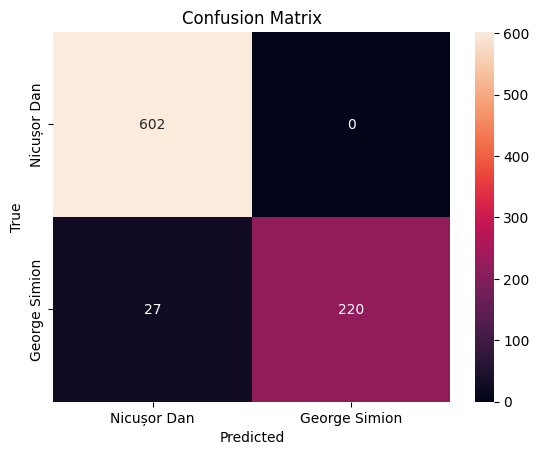

In [ ]:
# Predictions
y_pred = clf.predict(X_test)

# Basic reports
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

# Optional detailed metrics with average='weighted' for multiclass
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

print(f"Weighted Precision: {precision:.4f}")
print(f"Weighted Recall:    {recall:.4f}")
print(f"Weighted F1 Score:  {f1:.4f}")


# Confussion Matrix
cm = confusion_matrix(y_test, y_pred, labels=candidate_names)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=candidate_names, yticklabels=candidate_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### Clustering

In [204]:
# Setup
known_data = complete_compound_data[complete_compound_data['Candidate Inferred'] != 'Unknown'].dropna(subset=['Cleaned Content']).copy()

vectorizer = TfidfVectorizer(max_features=1000)
X_text = vectorizer.fit_transform(known_data['Cleaned Content'])


X = pd.concat([
    pd.DataFrame(X_text.toarray(), index=known_data.index),
    known_data[['Sentiment Score Num', 'Emotion Score Num', 'Voted Probability', 'Likely to vote']]
], axis=1)


known_data shape: (1061, 24)
X_text shape: (1061, 1000)



------ TF-IDF + Sentiment + Voting Features ------


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Numar clustere detectate: 11


,Content,Sentiment,Emotion,Voted Probability,Likely to vote,Candidate Inferred
1529,Simion a luat apr 3 milioane jumatate de votur...,very negative,joy,0.0,-1.0,George Simion
1263,Abia aștept să intru dimineață la satele inund...,very negative,anticipation,0.0,-1.0,Nicușor Dan
1421,https://preview.redd.it/rrv9k7jvuqye1.png?widt...,very negative,anticipation,0.0,-1.0,Nicușor Dan
760,https://preview.redd.it/wmqrdvjgzk1f1.jpeg?wid...,very negative,anticipation,0.0,-1.0,George Simion
1035,E clar ca ND castiga in romania. Dar in diaspo...,very negative,anticipation,0.0,-1.0,Nicușor Dan



Mean feature values per cluster:


,Sentiment Score Num,Emotion Score Num,Voted Probability,Likely to vote
cluster,,,,
0,-2.000000,1.0,0.000000,-1.000000
1,0.000000,1.0,1.000000,1.000000
2,-1.000000,1.0,0.095238,0.000000
3,-2.000000,1.0,1.000000,-1.000000
4,2.000000,1.0,1.000000,3.000000
5,-2.000000,-1.0,0.000000,-3.000000
6,1.000000,1.0,1.000000,2.000000
7,2.000000,-1.0,1.000000,1.000000
8,0.092593,-1.0,0.129630,-0.907407



Candidate distribution per cluster:


cluster  Candidate Inferred
0        Nicușor Dan           0.719243
         George Simion         0.280757
1        Nicușor Dan           0.642202
         George Simion         0.357798
2        Nicușor Dan           0.809524
         George Simion         0.190476
3        Nicușor Dan           0.638554
         George Simion         0.361446
4        Nicușor Dan           0.576923
         George Simion         0.423077
5        Nicușor Dan           0.782609
         George Simion         0.217391
6        Nicușor Dan           0.750000
         George Simion         0.250000
7        Nicușor Dan           0.647059
         George Simion         0.352941
8        Nicușor Dan           0.833333
         George Simion         0.166667
9        Nicușor Dan           0.692308
         George Simion         0.307692
10       Nicușor Dan           1.000000
Name: proportion, dtype: float64

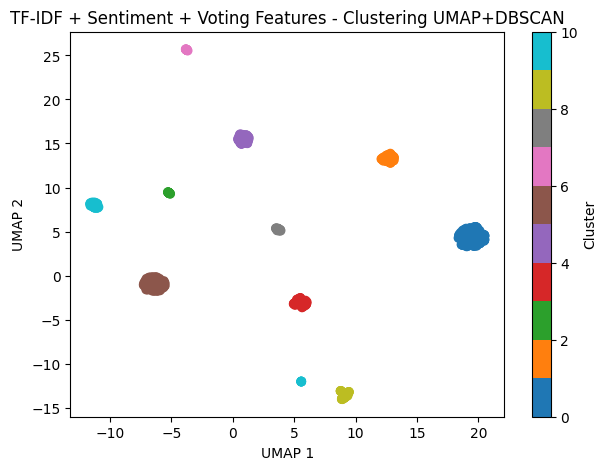

In [211]:
def cluster_and_score_umap_dbscan(X, known_data, label=""):
    print(f"\n------ {label} ------")

    if issparse(X):
        X_dense = X.toarray()
    else:
        X_dense = X

    X_dense = np.nan_to_num(X_dense)

    reducer = umap.UMAP(random_state=42)
    embedding = reducer.fit_transform(X_dense)

    clustering = DBSCAN(eps=0.8, min_samples=5).fit(embedding)
    clusters = clustering.labels_

    # Check length match before assignment
    if len(clusters) != len(known_data):
        raise ValueError(f"Clusters length {len(clusters)} does not match known_data length {len(known_data)}")

    known_data = known_data.copy()
    known_data['cluster'] = clusters

    n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
    print(f"Numar clustere detectate: {n_clusters}")

    i = 0
    if i in clusters:
        cluster_i = known_data[known_data['cluster'] == i]
        display(cluster_i[['Content', 'Sentiment', 'Emotion', 'Voted Probability', 'Likely to vote', 'Candidate Inferred']].sample(5))

    print("\nMean feature values per cluster:")
    display(known_data.groupby('cluster')[['Sentiment Score Num', 'Emotion Score Num', 'Voted Probability', 'Likely to vote']].mean())

    print("\nCandidate distribution per cluster:")
    display(known_data.groupby('cluster')['Candidate Inferred'].value_counts(normalize=True))

    plt.figure(figsize=(7,5))
    plt.scatter(embedding[:,0], embedding[:,1], c=clusters, cmap='tab10')
    plt.title(f"{label} - Clustering UMAP+DBSCAN")
    plt.xlabel("UMAP 1")
    plt.ylabel("UMAP 2")
    plt.colorbar(label="Cluster")
    plt.show()

cluster_and_score_umap_dbscan(X, known_data, label="TF-IDF + Sentiment + Voting Features")


# Statistics and Plots
In this section we are making plots to visualize the statistics in this project

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

cleaned_compound_data , cleaned_compound_csv_path = save_to_csv(cleaned_compound_data, project_root, 'cleaned_compound_data.csv')

display(complete_compound_data)

,Platform,Source Title,Author,Content,Likes,Replies,Created At,Extra Info,Cleaned Content,Tokens,Bigrams,Trigrams,Top TFIDF Term,Top TFIDF Bigram,Top TFIDF Trigram,Sentiment,Sentiment Score,Emotion,Emotion Score,Voted Probability,Sentiment Score Num,Emotion Score Num,Likely to vote,Candidate Inferred
0,Reddit,Statistici Alegeri 2025 - Thread,you_got_leads,Update - Duminica 13:00 - Romania Varsta/Sex/M...,179,NaN,2025-05-18 10:22:44,"{'post_id': '1koth82', 'comment_id': 'msxlmz8'...",update duminică 13:00 romania varsta/sex/mediu...,"[update, duminică, 13:00, romania, varsta/sex/...","[update_duminică, duminică_13:00, 13:00_romani...","[update_duminică_13:00, duminică_13:00_romania...",crestere,+20%_final,+20%_final_trend,very negative,0.407888,joy,0.252571,0.0,-2.0,1,-1.0,Unknown
1,Reddit,Statistici Alegeri 2025 - Thread,you_got_leads,"O sa iau o pauza, e deja noapte unde sunt si t...",170,NaN,2025-05-18 12:44:41,"{'post_id': '1koth82', 'comment_id': 'msy2k2i'...",lua pauza noapte tre eu pastrez energie rezultat,"[lua, pauza, noapte, tre, eu, pastrez, energie...","[lua_pauza, pauza_noapte, noapte_tre, tre_eu, ...","[lua_pauza_noapte, pauza_noapte_tre, noapte_tr...",pauza,energie_rezultat,eu_pastrez_energie,very negative,0.325992,anticipation,0.320264,0.0,-2.0,1,-1.0,Unknown
2,Reddit,Statistici Alegeri 2025 - Thread,you_got_leads,Update - Duminica 10:00 - Romania Varsta/Sex/M...,106,NaN,2025-05-18 07:16:10,"{'post_id': '1koth82', 'comment_id': 'msx3to1'...",update duminică 10:00 romania varsta/sex/mediu...,"[update, duminică, 10:00, romania, varsta/sex/...","[update_duminică, duminică_10:00, 10:00_romani...","[update_duminică_10:00, duminică_10:00_romania...",21,"+1,5m_vot","+1,5m_vot_extră",very negative,0.488166,joy,0.445320,0.0,-2.0,1,-1.0,Nicușor Dan
3,Reddit,Statistici Alegeri 2025 - Thread,you_got_leads,Mulțumesc tuturor pentru susținere! 🙌 \n \nF...,99,NaN,2025-05-18 15:17:48,"{'post_id': '1koth82', 'comment_id': 'msysp1a'...",susținere eu scrie întreba buymeacoffee/revolu...,"[susținere, eu, scrie, întreba, buymeacoffee/r...","[susținere_eu, eu_scrie, scrie_întreba, întreb...","[susținere_eu_scrie, eu_scrie_întreba, scrie_î...",presati,buymeacoffee/revolut_deschide,buymeacoffee/revolut_deschide_pagină,very negative,0.367046,joy,0.167503,0.0,-2.0,1,-1.0,Unknown
4,Reddit,Statistici Alegeri 2025 - Thread,watson_m,Eu ma astept asa:\n\n<55% prezenta - castiga G...,188,NaN,2025-05-17 13:54:35,"{'post_id': '1koth82', 'comment_id': 'msskut9'...",astept < 55% prezent castigă gs 55-60% \>60% c...,"[astept, <, 55%, prezent, castigă, gs, 55-60%,...","[astept_<, <_55%, 55%_prezent, prezent_castigă...","[astept_<_55%, <_55%_prezent, 55%_prezent_cast...",55,55-60%_\>60%,55%_prezent_castigă,very negative,0.422857,anticipation,0.333710,0.0,-2.0,1,-1.0,Unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2946,YouTube,Top comment ID: UgxqEN5y3pK3Vg4Ka9V4AaABAg,@simonamorar3722,❤❤❤ Simion Montréal Canada,0,[],2025-05-10T14:05:53Z,"{'video_id': '1N76UD-o95I', 'reply_count': 0}",simion montréal canada,"[simion, montréal, canada]","[simion_montréal, montréal_canada]",[simion_montréal_canada],montréal,montréal_canada,simion_montréal_canada,very positive,0.275819,anticipation,0.120840,1.0,2.0,1,3.0,George Simion
2947,YouTube,Top comment ID: UgxIfKSRsOEioIS3iBd4AaABAg,@BOIANGUEMIREL,Niste hoti II cat si tu nñmucusor Dan si nici ...,0,[],2025-05-10T14:00:29Z,"{'video_id': '1N76UD-o95I', 'reply_count': 0}",hoti nñmucusor dan simion stie gesiomñna,"[hoti, nñmucusor, dan, simion, stie, gesiomñna]","[hoti_nñmucusor, nñmucusor_dan, dan_simion, si...","[hoti_nñmucusor_dan, nñmucusor_dan_simion, dan...",gesiomñna,hoti_nñmucusor,dan_simion_stie,very negative,0.240764,anticipation,0.117818,0.0,-2.0,1,-1.0,Unknown
2948,YouTube,Top comment ID: UgxJYw-O2vSzdq8D_M94AaABAg,@silviutarcaci499,Votez George Simion presedinte.,0,[],2025-05-10T13:56:56Z,"{'video_id': '1N76UD-o95I', 'reply_count': 0}",votez georg

### N-Grams

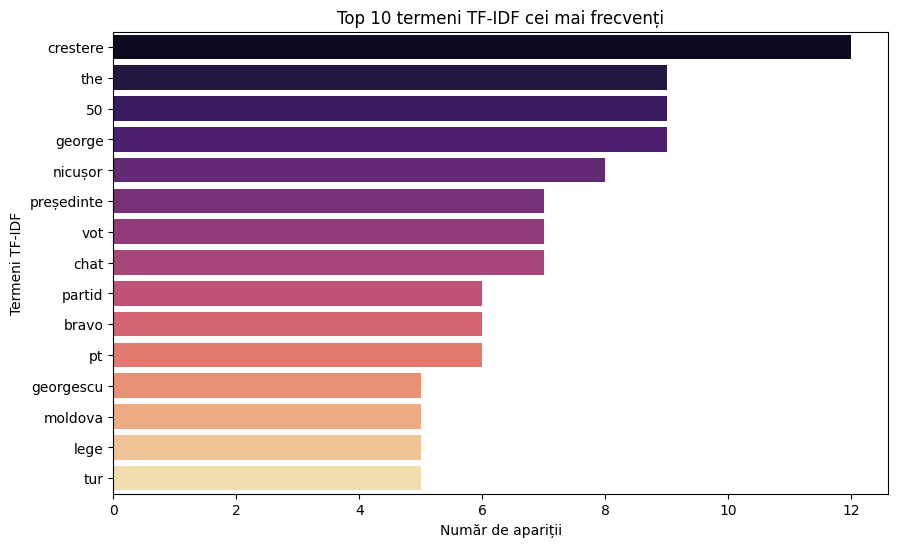

In [ ]:
top_terms = complete_compound_data['Top TFIDF Term'].value_counts().head(15)

plt.figure(figsize=(10,6))
sns.barplot(x=top_terms.values, y=top_terms.index, palette='magma')
plt.title('Top 10 termeni TF-IDF cei mai frecvenți')
plt.xlabel('Număr de apariții')
plt.ylabel('Termeni TF-IDF')
plt.show()


/tmp/ipython-input-167-2828975514.py:29: UserWarning: Glyph 127479 (\N{REGIONAL INDICATOR SYMBOL LETTER R}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127479 (\N{REGIONAL INDICATOR SYMBOL LETTER R}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


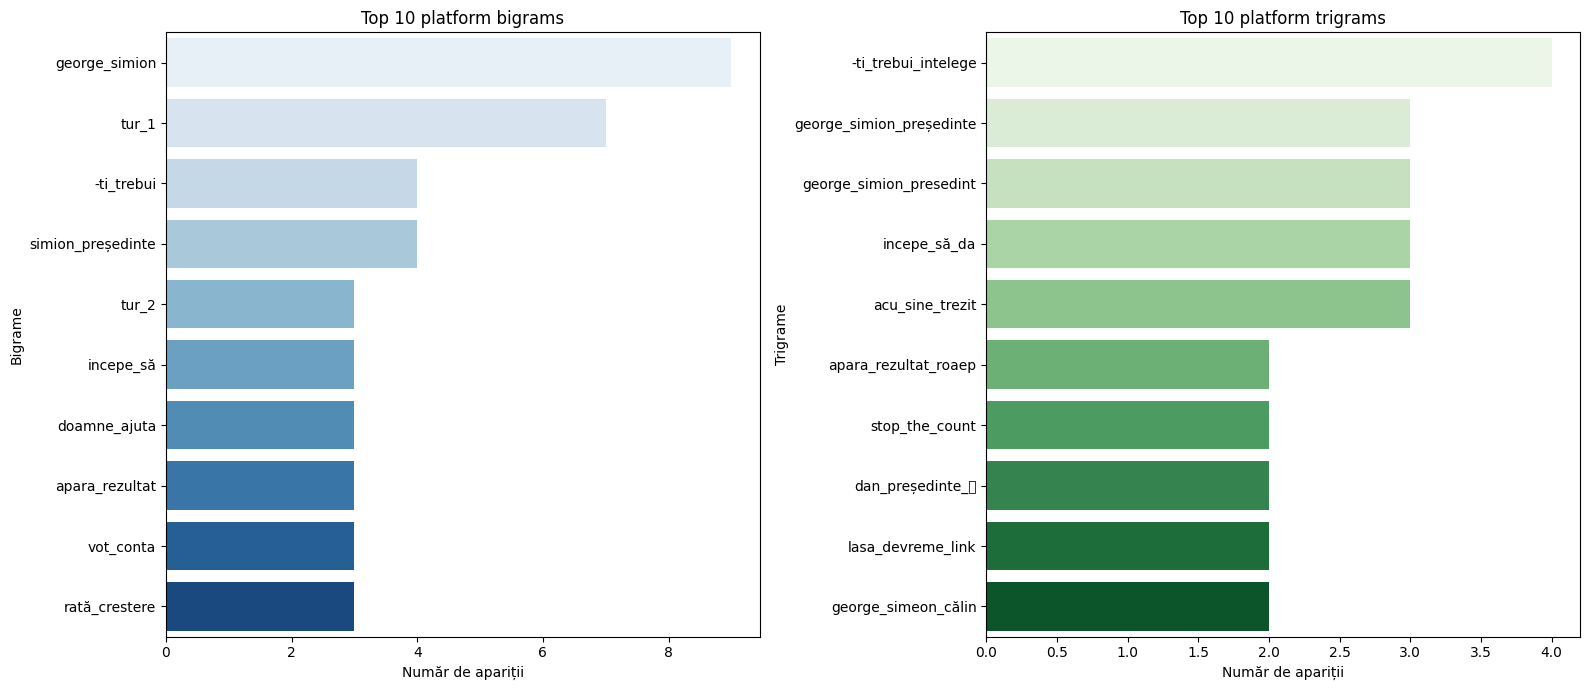

In [ ]:
top_bigrams = (
    complete_compound_data['Top TFIDF Bigram']
    .dropna()
    .loc[lambda x: x.str.strip() != '']
    .value_counts()
    .head(10)
)

top_trigrams = (
    complete_compound_data['Top TFIDF Trigram']
    .dropna()
    .loc[lambda x: x.str.strip() != '']
    .value_counts()
    .head(10)
)

fig, axs = plt.subplots(1, 2, figsize=(16,7))

sns.barplot(x=top_bigrams.values, y=top_bigrams.index, palette='Blues', ax=axs[0])
axs[0].set_title('Top 10 platform bigrams')
axs[0].set_xlabel('Număr de apariții')
axs[0].set_ylabel('Bigrame')

sns.barplot(x=top_trigrams.values, y=top_trigrams.index, palette='Greens', ax=axs[1])
axs[1].set_title('Top 10 platform trigrams')
axs[1].set_xlabel('Număr de apariții')
axs[1].set_ylabel('Trigrame')

plt.tight_layout()
plt.show()



### Sentiments and emotions

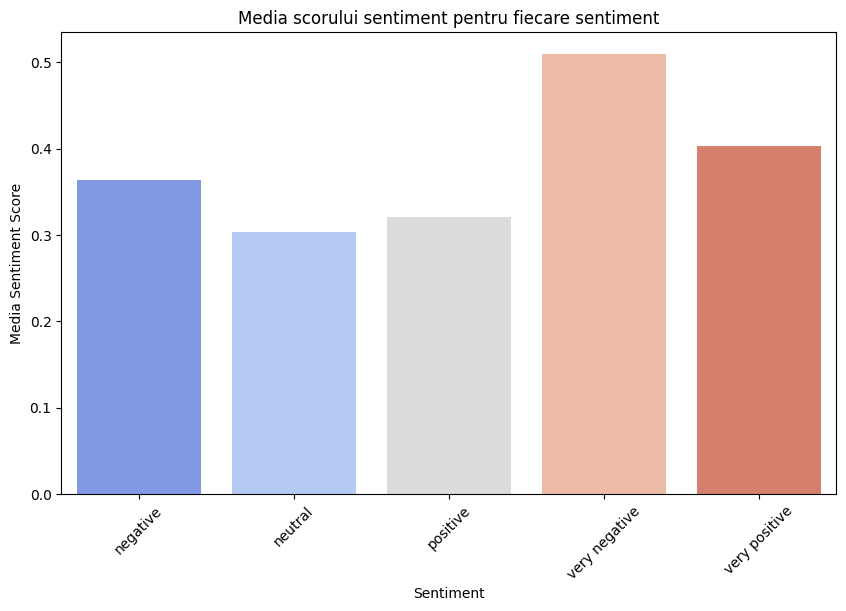

In [ ]:
sentiment_avg = complete_compound_data[complete_compound_data['Sentiment'].str.lower() != 'unknown'].dropna(subset=['Sentiment']).groupby('Sentiment')['Sentiment Score'].mean().reset_index()

plt.figure(figsize=(10,6))
sns.barplot(x='Sentiment', y='Sentiment Score', data=sentiment_avg, palette='coolwarm')
plt.title('Media scorului sentiment pentru fiecare sentiment')
plt.ylabel('Media Sentiment Score')
plt.xlabel('Sentiment')
plt.xticks(rotation=45)
plt.show()


ERROR:asyncio:Unclosed client session
client_session: <aiohttp.client.ClientSession object at 0x7f7776478390>


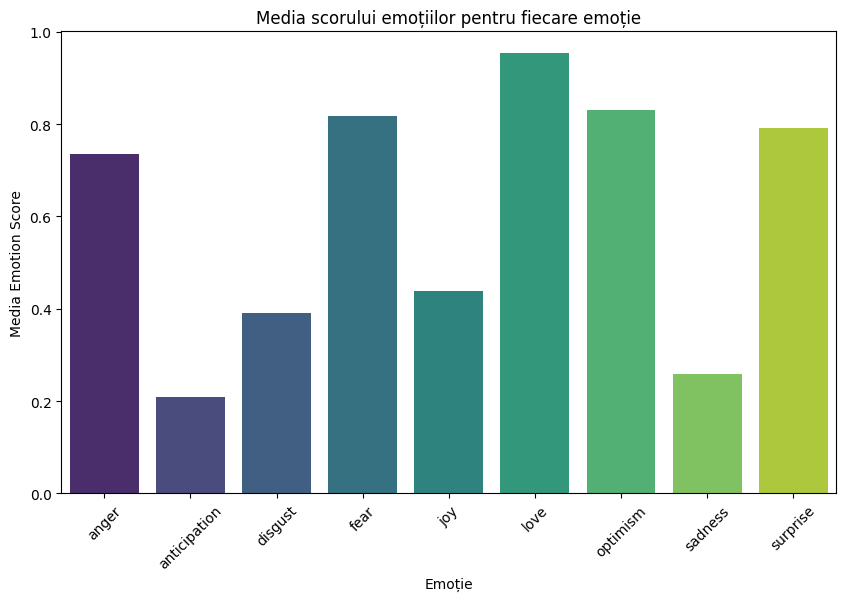

In [ ]:
emotion_avg = complete_compound_data[complete_compound_data['Emotion'].str.lower() != 'unknown'].dropna(subset=['Emotion']).groupby('Emotion')['Emotion Score'].mean().reset_index()

plt.figure(figsize=(10,6))
sns.barplot(x='Emotion', y='Emotion Score', data=emotion_avg, palette='viridis')
plt.title('Media scorului emoțiilor pentru fiecare emoție')
plt.ylabel('Media Emotion Score')
plt.xlabel('Emoție')
plt.xticks(rotation=45)
plt.show()


### Votes

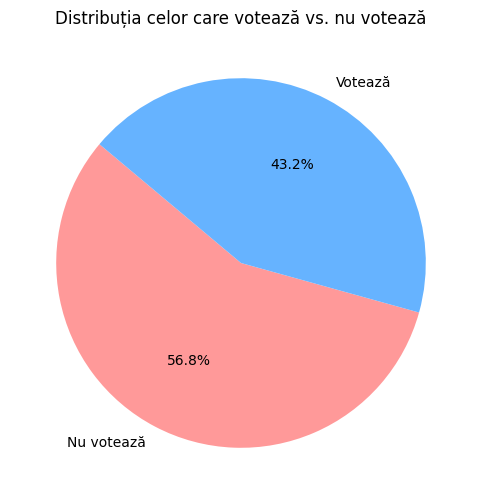

In [ ]:

vote_counts = complete_compound_data['Voted Probability'].value_counts()

labels = ['Nu votează', 'Votează']
sizes = [vote_counts.get(0,0), vote_counts.get(1,0)]

plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=['#ff9999','#66b3ff'], startangle=140)
plt.title('Distribuția celor care votează vs. nu votează')
plt.show()


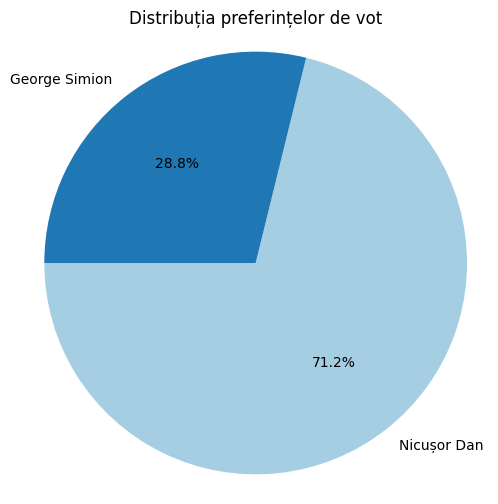

In [ ]:
votes_per_candidate = complete_compound_data[complete_compound_data['Candidate Inferred'] != 'Unknown']['Candidate Inferred'].value_counts()

plt.figure(figsize=(6,6))
plt.pie(votes_per_candidate.values,
        labels=votes_per_candidate.index,
        autopct='%1.1f%%',
        startangle=180,
        colors=plt.cm.Paired.colors)
plt.title('Distribuția preferințelor de vot')
plt.axis('equal')
plt.show()
